> `nhập các thư viện sử dụng`

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
  print('use: GPU')
else:
  print('use: CPU')

use: CPU


In [2]:
DATASET_DIR = "./data-augement/images-generate"
CATEGORIES = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"]

> `Nhập tập dữ liệu từ thư mục images-generate (bao gồm 20.000 ảnh)`

In [3]:
training_data = []
def create_training_data() -> None:
  for category in CATEGORIES:
    path = os.path.join(DATASET_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        training_data.append([img_array, class_num])
      except Exception as e:
        pass
      
create_training_data()
print(len(training_data))

20000


> `Trộn ngẫu nhiên tập dữ liệu`

In [4]:
import random
random.shuffle(training_data)

> `Tạo tập x_train và y_train`
- x_train là mảng chứa 20.000 ảnh, mỗi ảnh là một mảng hai chiều có kích thước 28 x 28
- Giá trị y_train là nhãn của x_train tương ứng (vd: x_train: ảnh số mười, y_train: 10)

In [5]:
input_shape = (28, 28, 1)
num_classes = 10

x_train = []
y_train = []

for features, label in training_data:
  x_train.append(features)
  y_train.append(label)

x_train = np.array(x_train).reshape(-1, 28, 28, 1)
x_train = x_train.astype("float32") / 255

y_train = np.array(y_train)
y_train = keras.utils.to_categorical(y_train, num_classes)

print(x_train.shape)
print(y_train.shape)

x_test = x_train[int(0.9 * 20000):,:]
y_test = y_train[int(0.9 * 20000):,:]
print(x_test.shape)
print(y_test.shape)

(20000, 28, 28, 1)
(20000, 10)
(2000, 28, 28, 1)
(2000, 10)


> `Khởi tạo mô hình mạng nơ ron tích chập (CNN)`

In [6]:
model = keras.Sequential(
  [
    keras.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
  ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

> `Thực hiện training dữ liệu, epochs = 20 (~ số lần đưa tập dữ liệu vào mạng nơ ron)`

In [7]:
batch_size = 128
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
H = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
141/141 [==============================] - 18s 119ms/step - loss: 1.6567 - accuracy: 0.4332 - val_loss: 0.9902 - val_accuracy: 0.7020
Epoch 2/20
141/141 [==============================] - 16s 117ms/step - loss: 0.8393 - accuracy: 0.7324 - val_loss: 0.5526 - val_accuracy: 0.8320
Epoch 3/20
141/141 [==============================] - 18s 129ms/step - loss: 0.5442 - accuracy: 0.8304 - val_loss: 0.3618 - val_accuracy: 0.9010
Epoch 4/20
141/141 [==============================] - 32s 226ms/step - loss: 0.4008 - accuracy: 0.8763 - val_loss: 0.2664 - val_accuracy: 0.9375
Epoch 5/20
141/141 [==============================] - 29s 206ms/step - loss: 0.3189 - accuracy: 0.9000 - val_loss: 0.2063 - val_accuracy: 0.9435
Epoch 6/20
141/141 [==============================] - 21s 150ms/step - loss: 0.2655 - accuracy: 0.9194 - val_loss: 0.1698 - val_accuracy: 0.9530
Epoch 7/20
141/141 [==============================] - 20s 142ms/step - loss: 0.2305 - accuracy: 0.9313 - val_loss: 0.1396 - val_ac

> `Đánh giá kết quả với tập dữ liệu test và lưu model vào thư mục out`

In [8]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

model.save('out/model_characters.h5')

63/63 [==============================] - 0s 7ms/step - loss: 0.0456 - accuracy: 0.9860
Test loss: 0.045638468116521835
Test accuracy: 0.9860000014305115


> `Trực quan hóa kết quả`

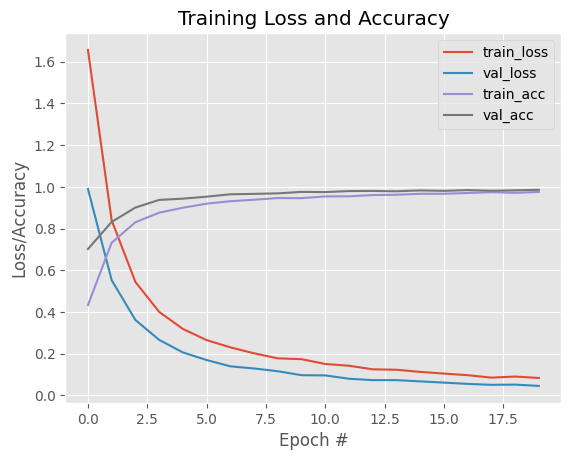

In [9]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")